# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

### Прудникова Анастасия Алексеевна М8О-114СВ-24

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from typing import Union, Tuple
from sklearn.datasets import fetch_openml


**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:

n_k1 = 8
n_k2 = 2
n_total = n_k1 + n_k2

p_k1 = n_k1 / n_total
p_k2 = n_k2 / n_total

entropy = -(p_k1 * math.log(p_k1) + p_k2 * math.log(p_k2))

print(f"Энтропия = {round(entropy, 2)}")


Энтропия = 0.5


Расчёт по формуле энтропии:

$ H = -\sum_{i=1}^{n} p_i \ln p_i $

где:
- n - количество классов,
- $p_i$ - вероятность (доля) объектов класса \( i \) в текущей вершине.


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [8]:
# Gini
p1_m = n_k1 / n_total
p2_m = n_k2 / n_total
H_m = p1_m * (1 - p1_m) + p2_m * (1 - p2_m)

H_left = 0
H_right = 0
Q = H_m - (n_k1 / n_total) * H_left - (n_k2 / n_total) * H_right

print(round(Q, 2))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [9]:
y_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

print(f"Предсказания модели равны {sum(y_values) / len(y_values)}")

Предсказания модели равны 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [10]:
from typing import Union, List, Tuple
from collections import Counter

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [59]:
def gini_index(y: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return np.sum(probs * (1 - probs))

def variance(y: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0
    return np.var(y)

def find_best_split(
    feature_vector: Union[np.ndarray], 
    target_vector: Union[np.ndarray],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    feature_vector, target_vector = np.asarray(feature_vector), np.asarray(target_vector)

    if feature_type == "real":
        sorted_idx = np.argsort(feature_vector)
        X_sorted, y_sorted = feature_vector[sorted_idx], target_vector[sorted_idx]

        diffs = X_sorted[1:] != X_sorted[:-1]
        thresholds = (X_sorted[1:] + X_sorted[:-1]) / 2
        thresholds = thresholds[diffs]

        n = len(y_sorted)
        left_counts = np.arange(1, n)
        right_counts = n - left_counts

        if task == "regression":
            cumsum_y = np.cumsum(y_sorted)
            cumsum_y2 = np.cumsum(y_sorted ** 2)

            left_sum = cumsum_y[:-1][diffs]
            right_sum = cumsum_y[-1] - left_sum
            left_sum2 = cumsum_y2[:-1][diffs]
            right_sum2 = cumsum_y2[-1] - left_sum2

            left_var = left_sum2 / left_counts[diffs] - (left_sum / left_counts[diffs]) ** 2
            right_var = right_sum2 / right_counts[diffs] - (right_sum / right_counts[diffs]) ** 2

            total_var = np.var(y_sorted)
            info_gain = total_var - (left_counts[diffs] / n) * left_var - (right_counts[diffs] / n) * right_var

        elif task == "classification":
            classes, counts = np.unique(y_sorted, return_counts=True)
            n_classes = len(classes)

            y_one_hot = (y_sorted.reshape(-1, 1) == classes).astype(int)  # shape (n_samples, n_classes)
            cumsum_class = np.cumsum(y_one_hot, axis=0)  # shape (n_samples, n_classes)

            left_probs = cumsum_class[:-1][diffs] / left_counts[diffs, None]  # shape (n_thresholds, n_classes)
            right_probs = (cumsum_class[-1] - cumsum_class[:-1][diffs]) / right_counts[diffs, None]

            left_gini = 1 - np.sum(left_probs ** 2, axis=1)
            right_gini = 1 - np.sum(right_probs ** 2, axis=1)

            total_probs = counts / n
            total_gini = 1 - np.sum(total_probs ** 2)

            info_gain = total_gini - (left_counts[diffs] / n) * left_gini - (right_counts[diffs] / n) * right_gini

        else:
            raise ValueError("task must be 'regression' or 'classification'")

    else:  # categorical
        unique_values = np.unique(feature_vector)
        info_gain = []
        thresholds = []

        for val in unique_values:
            left_mask = feature_vector == val
            right_mask = ~left_mask

            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue

            if task == "regression":
                left_impurity = variance(target_vector[left_mask])
                right_impurity = variance(target_vector[right_mask])
                total_var = variance(target_vector)
                gain = total_var - (left_mask.sum() / len(target_vector)) * left_impurity - (right_mask.sum() / len(target_vector)) * right_impurity
            elif task == "classification":
                left_impurity = gini_index(target_vector[left_mask])
                right_impurity = gini_index(target_vector[right_mask])
                total_gini = gini_index(target_vector)
                gain = total_gini - (left_mask.sum() / len(target_vector)) * left_impurity - (right_mask.sum() / len(target_vector)) * right_impurity
            else:
                raise ValueError("task must be 'regression' or 'classification'")

            thresholds.append(val)
            info_gain.append(gain)

        if len(info_gain) == 0:
            return np.array([]), np.array([]), None, -np.inf

        thresholds = np.array(thresholds)
        info_gain = np.array(info_gain)
    if len(info_gain) == 0:
        return np.array([]), np.array([]), None, -np.inf

    max_gain = np.max(info_gain)
    candidates = np.where(info_gain == max_gain)[0]
    best_idx = candidates[np.argmin(thresholds[candidates])]

    return thresholds, info_gain, thresholds[best_idx], info_gain[best_idx]


In [60]:
X = pd.DataFrame({
    "feature": [1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 11.0, 12.0, 13.0, 14.0]
})
y = np.array([1, 2, 1, 2, 1, 10, 11, 10, 11, 10])
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["feature"].to_numpy(),
    y,
    task="regression",
    feature_type="real"
)

print("Регрессия")
print("Пороги:", thresholds)
print("Приросты:", variances)
print("Лучший порог:", threshold_best)
print("Макс прирост:", variance_best)


Регрессия
Пороги: [ 1.5  2.5  3.5  4.5  7.5 10.5 11.5 12.5 13.5]
Приросты: [ 2.66777778  4.84        8.93761905 12.90666667 20.25       14.10666667
  8.42333333  5.29        1.86777778]
Лучший порог: 7.5
Макс прирост: 20.250000000000004


In [61]:
X = pd.DataFrame({
    "feature": [1, 2, 3, 4, 5, 10, 11, 12, 13, 14]
})
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

thresholds, ginis, threshold_best, gini_best = find_best_split(
    X["feature"].to_numpy(),
    y,
    task="classification",
    feature_type="real"
)

print("Классификация")
print("Пороги:", thresholds)
print("Приросты Джини:", ginis)
print("Лучший порог:", threshold_best)
print("Макс прирост:", gini_best)

Классификация
Пороги: [ 1.5  2.5  3.5  4.5  7.5 10.5 11.5 12.5 13.5]
Приросты Джини: [0.08       0.18       0.30857143 0.48       0.32       0.21333333
 0.13714286 0.08       0.03555556]
Лучший порог: 4.5
Макс прирост: 0.48


def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    pass

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [ ]:
#!pip3 install scikit-learn==1.0.2

^C


  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [66 lines of output]
      Partial import of sklearn during the build process.
      setup.py:128: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        from numpy.distutils.command.build_ext import build_ext  # noqa
      INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
      Traceback (most recent call last):
        File "C:\Users\nprud\Desktop\MAI\MAI\.conda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_proce

In [62]:
boston = fetch_openml(name='boston', version=1, as_frame=True)
X = boston.data
y = boston.target

print(X.head())
print(y[:5])

      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  
0  396.90   4.98  
1  396.90   9.14  
2  392.83   4.03  
3  394.63   2.94  
4  396.90   5.33  
0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64


In [63]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(),  
    y.to_numpy(),         
    task="regression",
    feature_type="real"
)

print("Всего порогов:", len(thresholds))
print("Лучший порог:", threshold_best)
print("Макс прирост:", variance_best)


Всего порогов: 503
Лучший порог: 6.68632
Макс прирост: 16.336309742318445


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

In [64]:
thresholds, info_gains, threshold_best, gain_best = find_best_split(
    X["CRIM"],
    y,
    task="regression",
    feature_type="real"
)

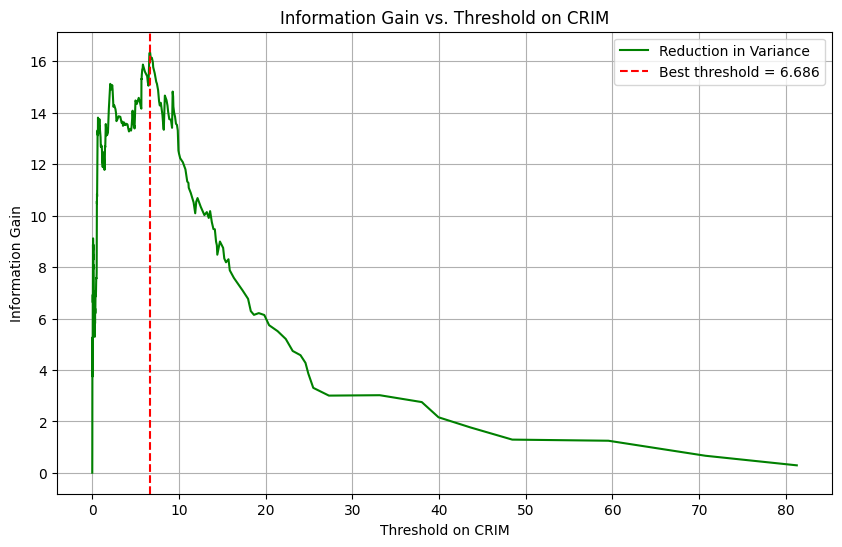

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, info_gains, label="Reduction in Variance", color='green')
plt.axvline(threshold_best, color='red', linestyle='--', label=f"Best threshold = {threshold_best:.3f}")
plt.xlabel("Threshold on CRIM")
plt.ylabel("Information Gain")
plt.title("Information Gain vs. Threshold on CRIM")
plt.legend()
plt.grid(True)
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [66]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict) -> None:
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, info_gain_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            feature_vector = sub_X[:, feature]

            _, _, threshold, info_gain = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if info_gain_best is None or info_gain > info_gain_best:
                feature_best = feature
                info_gain_best = info_gain
                threshold_best = threshold
                if feature_type == "real":
                    split = feature_vector < threshold_best
                else:
                    split = feature_vector == threshold_best

        if feature_best is None or np.sum(split) == 0 or np.sum(~split) == 0:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        else:
            node["category_split"] = threshold_best

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        feature_index = node["feature_split"]
        if self._feature_types[feature_index] == "real":
            if x[feature_index] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature_index] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._predict_node(x, self._tree) for x in X])


class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
students = pd.read_csv("students.csv")
students.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [ ]:
X = students[["STG", "SCG", "STR", "LPR", "PEG"]]
y = students["UNS"].to_numpy()

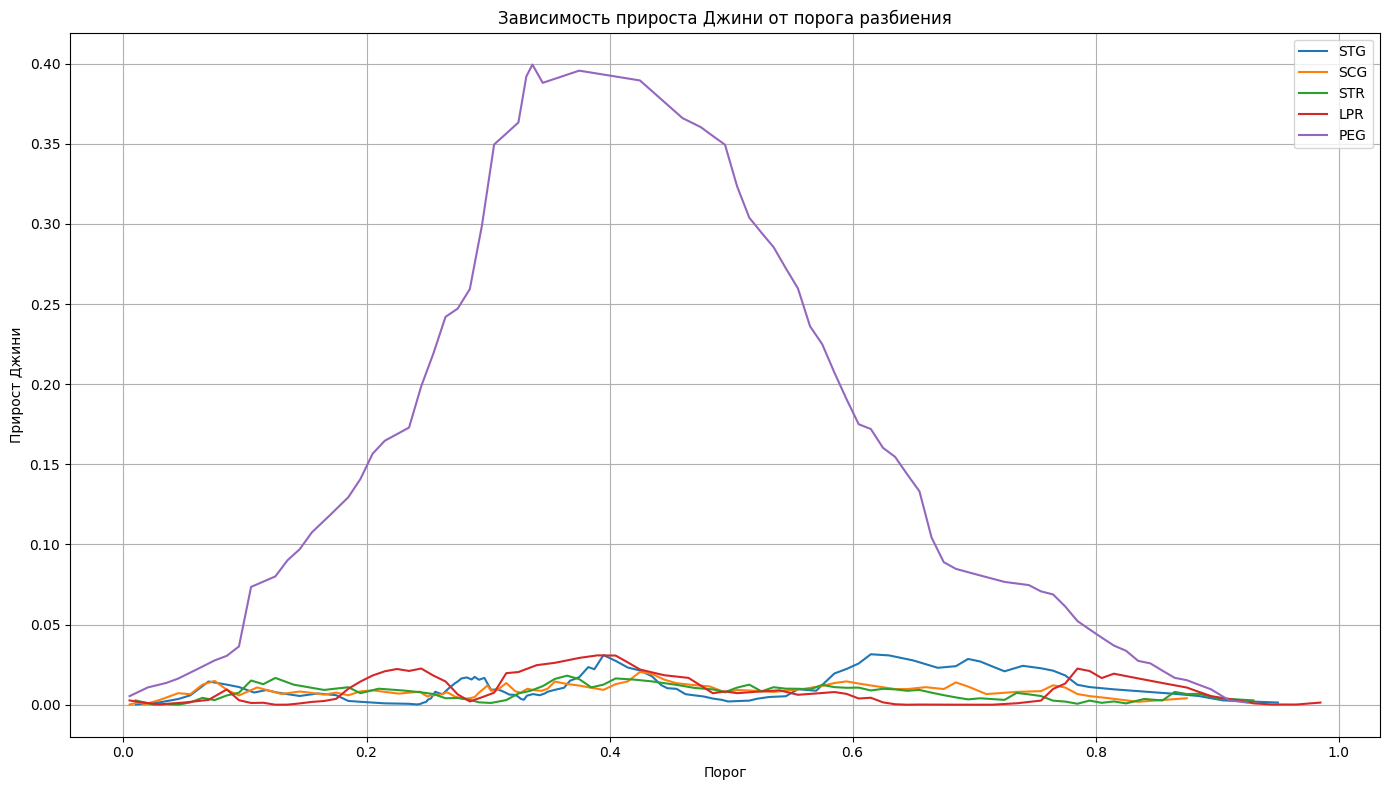

In [ ]:
plt.figure(figsize=(14, 8))

for i, column in enumerate(X.columns):
    thresholds, ginis, _, _ = find_best_split(X[column].values, y, task="classification", feature_type="real")
    plt.plot(thresholds, ginis, label=column)

plt.title("Зависимость прироста Джини от порога разбиения")
plt.xlabel("Порог")
plt.ylabel("Прирост Джини")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


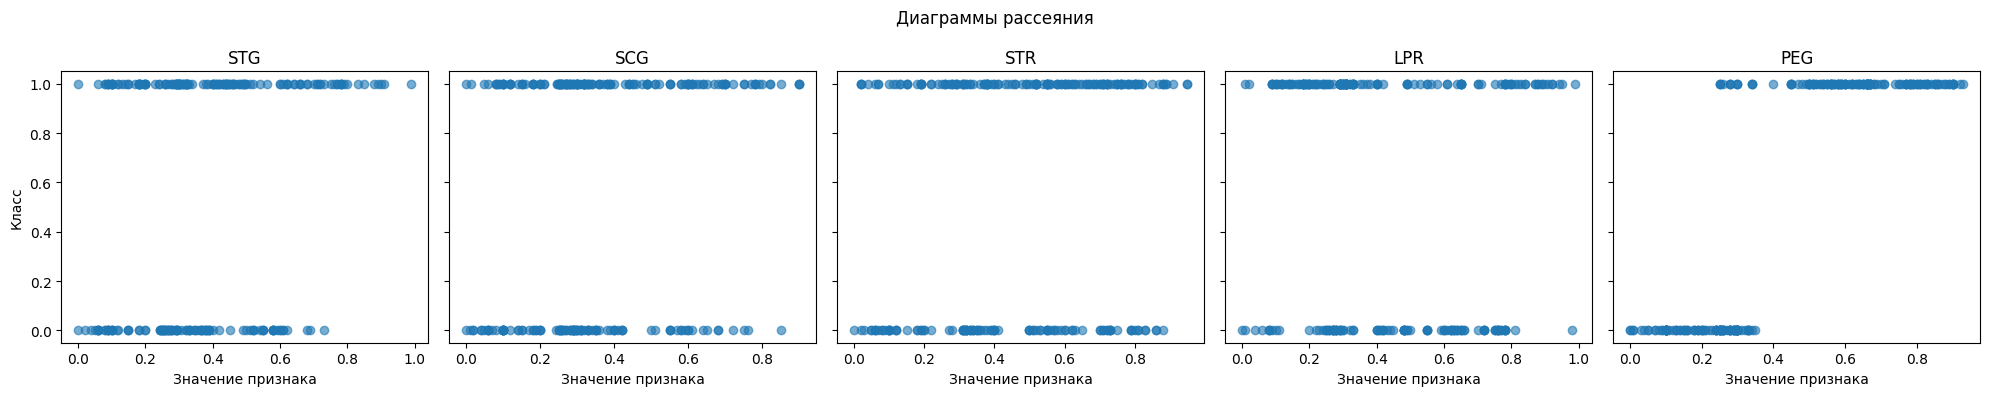

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, column in enumerate(X.columns):
    axes[i].scatter(X[column], y, alpha=0.6)
    axes[i].set_title(column)
    axes[i].set_xlabel("Значение признака")
    if i == 0:
        axes[i].set_ylabel("Класс")

plt.suptitle("Диаграммы рассеяния")
plt.tight_layout()
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Выборку нужно делить по признаку PEG, т.к. у него максимальный прирост Джини, остальные признаки дают прирост меньше 0.05.
Это согласуется с диаграммой рассеяния: по PEG классы хорошо разделены.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
mushroom = pd.read_csv("agaricus-lepiota.data")
mushroom.head

<bound method NDFrame.head of       p  x  s  n  t p.1  f  c n.1  k  ... s.2  w w.1 p.2 w.2  o p.3 k.1 s.3  u
0     e  x  s  y  t   a  f  c   b  k  ...   s  w   w   p   w  o   p   n   n  g
1     e  b  s  w  t   l  f  c   b  n  ...   s  w   w   p   w  o   p   n   n  m
2     p  x  y  w  t   p  f  c   n  n  ...   s  w   w   p   w  o   p   k   s  u
3     e  x  s  g  f   n  f  w   b  k  ...   s  w   w   p   w  o   e   n   a  g
4     e  x  y  y  t   a  f  c   b  n  ...   s  w   w   p   w  o   p   k   n  g
...  .. .. .. .. ..  .. .. ..  .. ..  ...  .. ..  ..  ..  .. ..  ..  ..  .. ..
8118  e  k  s  n  f   n  a  c   b  y  ...   s  o   o   p   o  o   p   b   c  l
8119  e  x  s  n  f   n  a  c   b  y  ...   s  o   o   p   n  o   p   b   v  l
8120  e  f  s  n  f   n  a  c   b  n  ...   s  o   o   p   o  o   p   b   c  l
8121  p  k  y  n  f   y  f  c   n  b  ...   k  w   w   p   w  o   e   w   v  l
8122  e  x  s  n  f   n  a  c   b  y  ...   s  o   o   p   o  o   p   o   c  l

[8123 rows x 23 colum

In [68]:
label_encoders = []
for column in mushroom.columns:
    le = LabelEncoder()
    mushroom[column] = le.fit_transform(mushroom[column])
    label_encoders.append(le)


In [69]:
X = mushroom.iloc[:, 1:].values
y = mushroom.iloc[:, 0].values 

X, y

(array([[5, 2, 4, ..., 2, 3, 5],
        [5, 2, 9, ..., 3, 2, 1],
        [0, 2, 8, ..., 3, 2, 3],
        ...,
        [2, 2, 4, ..., 0, 1, 2],
        [3, 3, 4, ..., 7, 4, 2],
        [5, 2, 4, ..., 4, 1, 2]], shape=(8124, 22)),
 array([1, 0, 0, ..., 0, 1, 0], shape=(8124,)))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
feature_types = ["categorical"] * X.shape[1]

tree = DecisionTree(feature_types=feature_types, task="classification")
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy = {accuracy:.4f}")

Accuracy = 1.0000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [97]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score

In [72]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

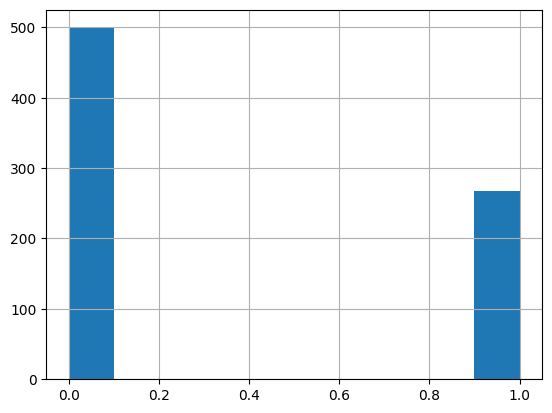

In [73]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [74]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)

print(f"Train shape: {X_train.shape} ({len(X_train) / len(data):.2f} of total)")
print(f"Validation shape: {X_val.shape} ({len(X_val) / len(data):.2f} of total)")
print(f"Test shape: {X_test.shape} ({len(X_test) / len(data):.2f} of total)")

Train shape: (375, 8) (0.49 of total)
Validation shape: (162, 8) (0.21 of total)
Test shape: (231, 8) (0.30 of total)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [86]:
max_depth_list = [3, 5, 7, 9, None] 
min_samples_leaf_list = [1, 2, 4, 6, 8]

best_f1 = 0
best_params = {}

In [87]:
for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)
        
        f1 = f1_score(y_val, y_val_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf}

In [88]:
print(f"Лучшие параметры: {best_params}, f1 на валидационной: {best_f1:.4f}")

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 1}, f1 на валидационной: 0.5455


In [89]:
final_clf = DecisionTreeClassifier(**best_params, random_state=42)
final_clf.fit(X_train_full, y_train_full)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [90]:
y_test_pred = final_clf.predict(X_test)
y_test_proba = final_clf.predict_proba(X_test)[:, 1] 

In [91]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

In [92]:
print("Test")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


Test
accuracy: 0.7662
precision: 0.8000
recall: 0.4444
AUC-ROC: 0.8182


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [93]:
bagging_clf = BaggingClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1 
)

In [94]:
bagging_clf.fit(X_train_full, y_train_full)

y_test_pred = bagging_clf.predict(X_test)
y_test_proba = bagging_clf.predict_proba(X_test)[:, 1]

In [95]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

print("Bagging (50 trees):")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Bagging (50 trees):
accuracy: 0.7532
precision: 0.6875
recall: 0.5432
AUC-ROC: 0.8269


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [98]:
max_depth_list = [3, 5, 7, 10, None]
min_samples_split_list = [2, 5, 10]

best_score = -np.inf
best_params = {}

f1_scorer = make_scorer(f1_score)

In [99]:
for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
        scores = cross_val_score(rf, X_train_full, y_train_full, cv=5, scoring=f1_scorer, n_jobs=-1)
        mean_score = scores.mean()
        
        print(f"max_depth={max_depth}, min_samples_split={min_samples_split}, mean F1={mean_score:.4f}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = {"max_depth": max_depth, "min_samples_split": min_samples_split}

best_params, best_score

max_depth=3, min_samples_split=2, mean F1=0.5872
max_depth=3, min_samples_split=5, mean F1=0.5829
max_depth=3, min_samples_split=10, mean F1=0.5860
max_depth=5, min_samples_split=2, mean F1=0.5922
max_depth=5, min_samples_split=5, mean F1=0.5817
max_depth=5, min_samples_split=10, mean F1=0.5795
max_depth=7, min_samples_split=2, mean F1=0.5765
max_depth=7, min_samples_split=5, mean F1=0.5866
max_depth=7, min_samples_split=10, mean F1=0.5824
max_depth=10, min_samples_split=2, mean F1=0.6049
max_depth=10, min_samples_split=5, mean F1=0.6321
max_depth=10, min_samples_split=10, mean F1=0.6202
max_depth=None, min_samples_split=2, mean F1=0.5841
max_depth=None, min_samples_split=5, mean F1=0.6065
max_depth=None, min_samples_split=10, mean F1=0.6334


({'max_depth': None, 'min_samples_split': 10}, np.float64(0.6334310134310134))

In [100]:
best_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train_full, y_train_full)

RandomForestClassifier(min_samples_split=10, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [101]:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

In [102]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)

In [103]:
print("\nRandom Forest с подобранными параметрами:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


Random Forest с подобранными параметрами:
Accuracy: 0.7403
Precision: 0.6567
Recall: 0.5432
AUC-ROC: 0.8207


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [104]:
n_estimators_list = list(range(1, 101, 5)) 
auc_scores = []

for n_trees in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_train_full, y_train_full)
    
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

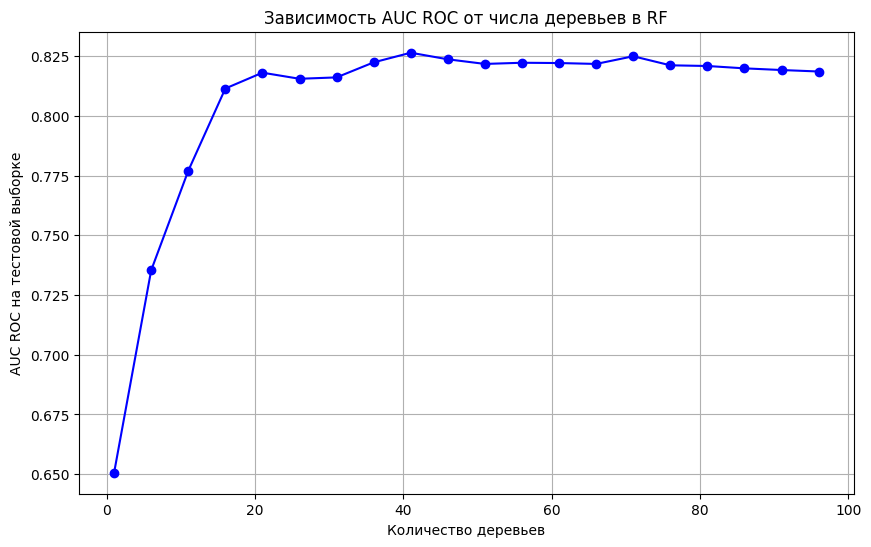

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, auc_scores, marker='o', color='blue')
plt.title('Зависимость AUC ROC от числа деревьев в RF')
plt.xlabel('Количество деревьев')
plt.ylabel('AUC ROC на тестовой выборке')
plt.grid(True)
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

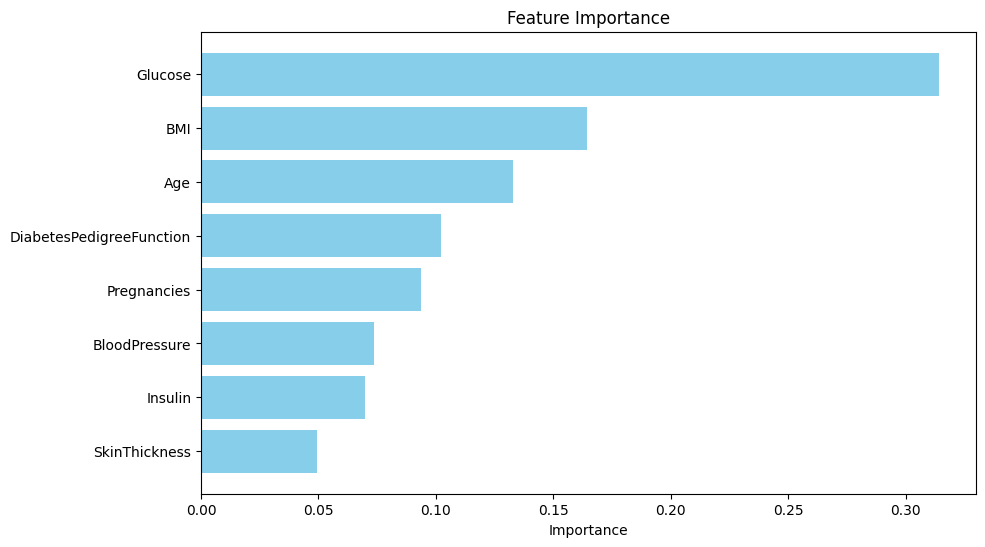

Наиболее важный признак: Glucose


In [107]:
feature_importances = best_rf.feature_importances_
feature_names = X_train_full.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

print("Наиболее важный признак:", importance_df.iloc[0]['feature'])